# Likelihood surface

Tony Wong (<anthony.e.wong@colorado.edu>)

## Read in the data, and uncertainties

Some preliminaries.

In [4]:
library(repr)
library(sn)
library(hexbin)
library(gplots)
library(plot3D)
library(MASS)

Actually read in the data. Using the CO2 uncertainty cutoff of 20 ppmv (minimum), so use that here too.

In [5]:
#dist <- 'ga'
dist <- 'be'
#dist <- 'ln'
#dist <- 'sn'

co2_uncertainty_cutoff <- 20
upper_bound_co2 <- 10000
lower_bound_co2 <- 0

if(dist=='ga') {filename.data <- '../input_data/CO2_Proxy_Foster2017_calib_GAMMA-co2_31Jul2018.csv'}
if(dist=='be') {filename.data <- '../input_data/CO2_Proxy_Foster2017_calib_BETA-co2_13Sep2018.csv'}
if(dist=='ln') {filename.data <- '../input_data/CO2_Proxy_Foster2017_calib_LN-co2_31Jul2018.csv'}
if(dist=='sn') {filename.data <- '../input_data/CO2_Proxy_Foster2017_calib_SN-co2_06Jun2017.csv'}

# Which proxy sets to assimilate? (set what you want to "TRUE", others to "FALSE")
data_to_assim <- cbind( c("paleosols" , TRUE),
                        c("alkenones" , TRUE),
                        c("stomata"   , TRUE),
                        c("boron"     , TRUE),
                        c("liverworts", TRUE) )

source('GEOCARB-2014_getData.R')

ind_data    <- which(data_to_assim[2,]==TRUE)
n_data_sets <- length(ind_data)
ind_assim   <- vector("list",n_data_sets)
for (i in 1:n_data_sets) {
  ind_assim[[i]] <- which(as.character(data_calib_all$proxy_type) == data_to_assim[1,ind_data[i]])
}

data_calib <- data_calib_all[unlist(ind_assim),]

# filtering out of some data points with too-narrow uncertainties in
# co2 (causing overconfidence in model simulations that match those data points
# well). set to +65%, - 30% uncertain range around the central estimate
if(co2_uncertainty_cutoff > 0) {
  co2_halfwidth <- 0.5*(data_calib$co2_high - data_calib$co2_low)
  ind_filter <- which(co2_halfwidth < co2_uncertainty_cutoff)
  ind_remove <- NULL
  for (ii in ind_filter) {
    range_original <- data_calib[ii,'co2_high']-data_calib[ii,'co2_low']
    range_updated  <- data_calib[ii,'co2']*0.95
    if (range_updated > range_original) {
      # update to the wider uncertain range if +65/-30% is wider
      data_calib[ii,'co2_high'] <- data_calib[ii,'co2']*1.65
      data_calib[ii,'co2_low']  <- data_calib[ii,'co2']*0.70
    } else {
      # otherwise, remove
      ind_remove <- c(ind_remove, ii)
    }
  }
  data_calib <- data_calib[-ind_filter,]    # removing all of the possibly troublesome points
  ##data_calib <- data_calib[-ind_remove,]    # remove only those the revised range does not help
}

## Sampling from the likelihood function

In [6]:
n_sample_per_point <- 5000
samples <- array(NA, c(nrow(data_calib)*n_sample_per_point, 2))

for (t in 1:nrow(data_calib)) {
    idx <- ((t-1)*n_sample_per_point+1):(t*n_sample_per_point)
    samples[idx,1] <- rep(data_calib$age[t], n_sample_per_point)
    if (dist=='ga') {
        samples[idx,2] <- rgamma(shape=data_calib$shape_co2[t], scale=data_calib$scale_co2[t],
                                 n=n_sample_per_point)
    } else if (dist=='be') {
        samples[idx,2] <- rbeta(shape1=data_calib$shape1_co2[t], shape2=data_calib$shape2_co2[t],
                                 n=n_sample_per_point)
        # need to scale beta distribution up to range from fitting
        samples[idx,2] <- lower_bound_co2+(upper_bound_co2-lower_bound_co2)*samples[idx,2]
    } else if (dist=='ln') {
        samples[idx,2] <- rlnorm(meanlog=data_calib$meanlog_co2[t], sdlog=data_calib$sdlog_co2[t],
                                 n=n_sample_per_point)
    } else if (dist=='sn') {
        samples[idx,2] <- rsn(xi=data_calib$xi_co2[t], omega=data_calib$omega_co2[t],
                              alpha=data_calib$alpha_co2[t], n=n_sample_per_point)
    }
}

dfSamples <- data.frame(samples)

## Plotting

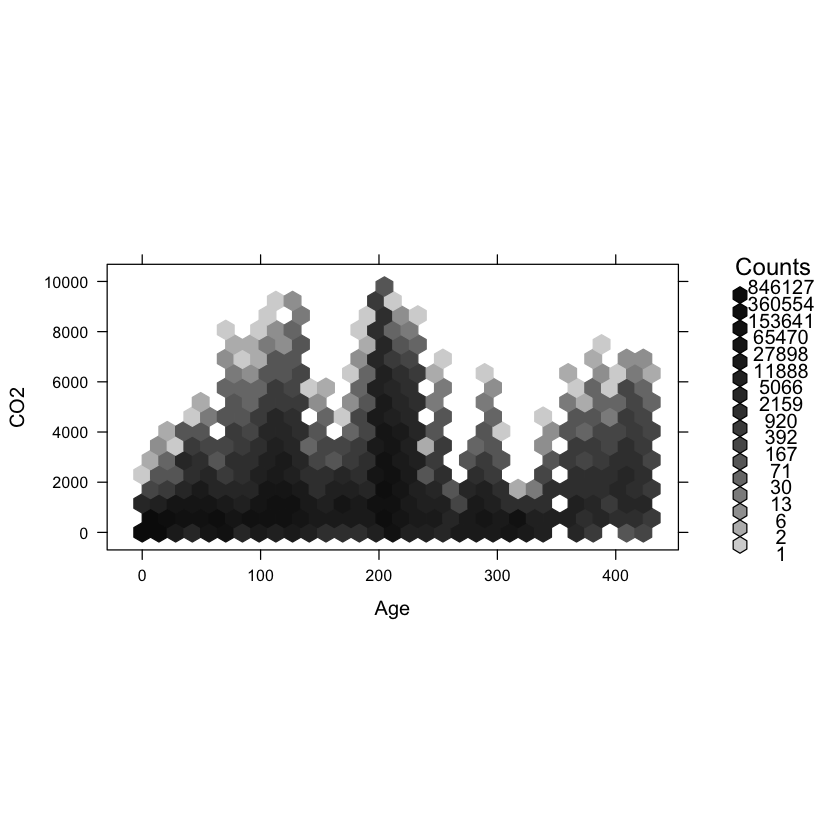

In [7]:
hexbinplot(dfSamples[,2]~dfSamples[,1], dfSamples, trans=log, inv=exp, asp=.5, xlab='Age', ylab='CO2')

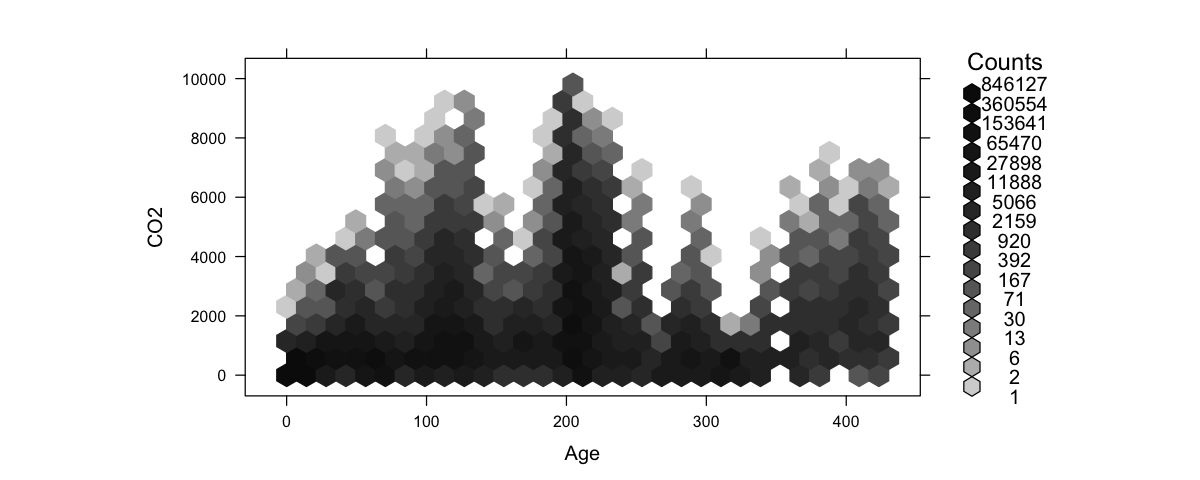

In [8]:
options(repr.plot.width=10, repr.plot.height=4)
hexbinplot(dfSamples[,2]~dfSamples[,1], dfSamples, trans=log, inv=exp, asp=.5, xlab='Age', ylab='CO2')

In [ ]:
options(repr.plot.width=6, repr.plot.height=4)
h2 <- hist2d(dfSamples, FUN=function(x) log(length(x)), xlab='Age', ylab='CO2')
lines(c(0,500),c(0,0))

In [ ]:
xy <- samples

nbins <- 20

x.bin <- seq(floor(min(xy[,1])), ceiling(max(xy[,1])), length=nbins)
y.bin <- seq(floor(min(xy[,2])), ceiling(max(xy[,2])), length=nbins)

freq <-  as.data.frame(table(findInterval(xy[,1], x.bin),findInterval(xy[,2], y.bin)))
freq[,1] <- as.numeric(freq[,1])
freq[,2] <- as.numeric(freq[,2])

freq2D <- diag(nbins)*0
freq2D[cbind(freq[,1], freq[,2])] <- freq[,3]

options(repr.plot.width=12, repr.plot.height=5)

par(mfrow=c(1,2))
image(x.bin, y.bin, log10(freq2D), col=terrain.colors(1024), xlab='Age', ylab='CO2')
contour(x.bin, y.bin, log10(freq2D), add=TRUE, col=rgb(1,1,1,.7))
lines(c(-100,500),c(0,0))

palette(terrain.colors(1024))
cols <- (freq2D[-1,-1] + freq2D[-1,-(nbins-1)] + freq2D[-(nbins-1),-(nbins-1)] + freq2D[-(nbins-1),-1])/4
persp(freq2D, col=cols, xlab='Age', ylab='CO2', phi=25, theta=45)

---
### Get model simulation

In [ ]:
# Read parameter information, set up the calibration parameters
filename.calibinput <- "../input_data/GEOCARB_input_summaries_calib_sig18.csv"
source('GEOCARB-2014_parameterSetup.R')

# initial fixed parameters estimate:
filename.par_fixed  <- '../output/par_deoptim_OPT1_04Jul2018.rds'
filename.covariance <- "../output/par_LHS2_sig18_04Jul2018.RData"

par_new <- readRDS(filename.par_fixed)
for (name in names(par_new)) {
if (name %in% parnames_fixed) {
  par_fixed0[match(name, parnames_fixed)] <- par_new[name]
}
if (name %in% parnames_calib) {
  par_calib0[match(name, parnames_calib)] <- par_new[name]
}
}
# need to strip the names or MCMC will break
names(par_calib0) <- NULL
names(par_fixed0) <- NULL

##==============================================================================
## Run the calibration
##====================

# need the physical model
source('model_forMCMC.R')
source('run_geocarbF.R')

model_out <- model_forMCMC(par_calib=par_calib0,
                           par_fixed=par_fixed0,
                           parnames_calib=parnames_calib,
                           parnames_fixed=parnames_fixed,
                           age=age,
                           ageN=ageN,
                           ind_const_calib=ind_const_calib,
                           ind_time_calib=ind_time_calib,
                           ind_const_fixed=ind_const_fixed,
                           ind_time_fixed=ind_time_fixed,
                           ind_expected_time=ind_expected_time,
                           ind_expected_const=ind_expected_const,
                           iteration_threshold=iteration_threshold)

---
### Build the smoothed likelihood surface

... From sampling the fitted beta distributions (or skew-normal? probably not though, because we want the hard bounds of 0 and 10,000 ppmv pCO2).

For a given time step (say, at $t = 200$ mya), collact all the data points that are within half a time step on either side. Endpoints are inclusive towards the present and exclusive on the past end.

In [ ]:
time <- model_out[,1]
n_time <- length(time)
dtime <- median(diff(time))
n_sample_per_point <- 5000
likelihood_fit <- vector('list', n_time)

for (tt in 1:n_time) {
    idx <- which(data_calib$age-time[tt] < 5 & data_calib$age-time[tt] >= -5)
    if (length(idx) > 0) {
        # sample from the distributions fit to each of the data points
        samples <- NULL
        for (ii in idx) {
            if (dist=='ga') {
                new_samples <- rgamma(shape=data_calib$shape_co2[ii], scale=data_calib$scale_co2[ii],
                                      n=n_sample_per_point)
            } else if (dist=='be') {
                new_samples <- rbeta(shape1=data_calib$shape1_co2[ii], shape2=data_calib$shape2_co2[ii],
                                     n=n_sample_per_point)
                new_samples <- lower_bound_co2+(upper_bound_co2-lower_bound_co2)*new_samples
            } else if (dist=='ln') {
                new_samples <- rlnorm(meanlog=data_calib$meanlog_co2[ii], sdlog=data_calib$sdlog_co2[ii],
                                      n=n_sample_per_point)
            } else if (dist=='sn') {
                new_samples <- rsn(xi=data_calib$xi_co2[ii], omega=data_calib$omega_co2[ii],
                                   alpha=data_calib$alpha_co2[ii], n=n_sample_per_point)
            }
            samples <- c(samples, new_samples)
        }
        # fit KDE
        density_fit <- density(samples)
        # fit linear interpolation around KDE
        likelihood_fit[[tt]] <- approxfun(density_fit)
    }
}

In [ ]:
co2 <- seq(from=1,to=10000,by=10)

# a representative cross-sectional plot
f_fit <- likelihood_fit[[20]](co2)
plot(co2,f_fit, xlab='CO2 (ppmv)', ylab='density')

In [ ]:
idx_data <- NULL
for (tt in 1:n_time) {
    if(!is.null(likelihood_fit[[tt]])) {idx_data <- c(idx_data,tt)}
}
n_data_fit <- length(idx_data)

In [ ]:
likelihood_smoothed <- array(NA, c(length(co2), n_time))
for (ii in idx_data) {
    likelihood_smoothed[,ii] <- likelihood_fit[[ii]](co2)
}

In [ ]:
image2D(t(likelihood_smoothed), time, co2, col=terrain.colors(30), ylim=c(0,2000), contour=TRUE)

### Build function to evaluate smoothed likelihood (log)

**Input:**  GEOCARB model output (age, co2, o2)

**Output:**  Joint likelihood from the smoothed likelihood object

Should set function up so that we have the `ind_mod2obs` that extracts the proper indices (ages) of the CO2 vaues to feed into the likelihood surface.

In [ ]:
x <- matrix(cbind(c( rep(1,nrow(data_calib)) , data_calib$age )), nrow=nrow(data_calib))
y <- data_calib$co2
fit <- msn.mle(x, y)

In [ ]:
names(fit$dp)

In [ ]:
fit$dp

In [ ]:
#rmsn(n=1, xi=rep(0,length(alpha)), Omega, alpha, tau=0, dp=NULL)
samp <- rmsn(n=10000, xi=0, fit$dp$Omega, fit$dp$alpha, tau=0, dp=NULL)

In [ ]:
dim(samp)

In [ ]:
plot(fit)

---

### 2D KDE approach

Sample from the fitted skew-normal distributions, then fit a multivariate KDE to the entire bunch of samples. Do not weight samples from the same time step differently, because more data there means more likelihood function weight should be there.

In [ ]:
#dist <- 'ga'
#dist <- 'be'
#dist <- 'ln'
dist <- 'sn'

co2_uncertainty_cutoff <- 20
upper_bound_co2 <- 10000
lower_bound_co2 <- 0

if(dist=='ga') {filename.data <- '../input_data/CO2_Proxy_Foster2017_calib_GAMMA-co2_31Jul2018.csv'}
if(dist=='be') {filename.data <- '../input_data/CO2_Proxy_Foster2017_calib_BETA-co2_13Sep2018.csv'}
if(dist=='ln') {filename.data <- '../input_data/CO2_Proxy_Foster2017_calib_LN-co2_31Jul2018.csv'}
if(dist=='sn') {filename.data <- '../input_data/CO2_Proxy_Foster2017_calib_SN-co2_06Jun2017.csv'}

# Which proxy sets to assimilate? (set what you want to "TRUE", others to "FALSE")
data_to_assim <- cbind( c("paleosols" , TRUE),
                        c("alkenones" , TRUE),
                        c("stomata"   , TRUE),
                        c("boron"     , TRUE),
                        c("liverworts", TRUE) )

source('GEOCARB-2014_getData.R')

ind_data    <- which(data_to_assim[2,]==TRUE)
n_data_sets <- length(ind_data)
ind_assim   <- vector("list",n_data_sets)
for (i in 1:n_data_sets) {
  ind_assim[[i]] <- which(as.character(data_calib_all$proxy_type) == data_to_assim[1,ind_data[i]])
}

data_calib <- data_calib_all[unlist(ind_assim),]

# filtering out of some data points with too-narrow uncertainties in
# co2 (causing overconfidence in model simulations that match those data points
# well). set to +65%, - 30% uncertain range around the central estimate
if(co2_uncertainty_cutoff > 0) {
  co2_halfwidth <- 0.5*(data_calib$co2_high - data_calib$co2_low)
  ind_filter <- which(co2_halfwidth < co2_uncertainty_cutoff)
  ind_remove <- NULL
  for (ii in ind_filter) {
    range_original <- data_calib[ii,'co2_high']-data_calib[ii,'co2_low']
    range_updated  <- data_calib[ii,'co2']*0.95
    if (range_updated > range_original) {
      # update to the wider uncertain range if +65/-30% is wider
      data_calib[ii,'co2_high'] <- data_calib[ii,'co2']*1.65
      data_calib[ii,'co2_low']  <- data_calib[ii,'co2']*0.70
    } else {
      # otherwise, remove
      ind_remove <- c(ind_remove, ii)
    }
  }
  data_calib <- data_calib[-ind_filter,]    # removing all of the possibly troublesome points
  ##data_calib <- data_calib[-ind_remove,]    # remove only those the revised range does not help
}

sampling from the fitted skew-normals (or other distributions)

In [ ]:
n_sample_per_point <- 5000
samples <- array(NA, c(nrow(data_calib)*n_sample_per_point, 2))

for (t in 1:nrow(data_calib)) {
    idx <- ((t-1)*n_sample_per_point+1):(t*n_sample_per_point)
    samples[idx,1] <- rep(data_calib$age[t], n_sample_per_point)
    if (dist=='ga') {
        samples[idx,2] <- rgamma(shape=data_calib$shape_co2[t], scale=data_calib$scale_co2[t],
                                 n=n_sample_per_point)
    } else if (dist=='be') {
        samples[idx,2] <- rbeta(shape1=data_calib$shape1_co2[t], shape2=data_calib$shape2_co2[t],
                                 n=n_sample_per_point)
        # need to scale beta distribution up to range from fitting
        samples[idx,2] <- lower_bound_co2+(upper_bound_co2-lower_bound_co2)*samples[idx,2]
    } else if (dist=='ln') {
        samples[idx,2] <- rlnorm(meanlog=data_calib$meanlog_co2[t], sdlog=data_calib$sdlog_co2[t],
                                 n=n_sample_per_point)
    } else if (dist=='sn') {
        samples[idx,2] <- rsn(xi=data_calib$xi_co2[t], omega=data_calib$omega_co2[t],
                              alpha=data_calib$alpha_co2[t], n=n_sample_per_point)
    }
}

dfSamples <- data.frame(samples)

In [ ]:
fit <- kde2d(dfSamples[,1], dfSamples[,2], n=c(58,5000), lims = c(0,580, 0,10000))

In [ ]:
# fit linear interpolation around KDE
fit_func <- approxfun(fit)

In [ ]:
fit_func

In [ ]:
likelihood_kde <- array(NA, dim=c(length(time), length(co2)))
for (tt in time) {
    for (cc in co2) {
        likelihood_kde[tt,cc] <- fit_func(tt,cc)
    }
}

In [ ]:
image2D(fit, time, co2, ylim=c(0,2000), contour=TRUE)

In [ ]:
image2D(t(likelihood_smoothed), time, co2, col=terrain.colors(30), ylim=c(0,2000), contour=TRUE)